# Overview

This explores the transfer learning of Resnet-50 as the encoder for the U-Net architecture on the chest pneumonia dataset

# Environment

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install Jarvis library
%pip install jarvis-md

### Imports

Use the following lines to import any needed libraries:

In [45]:
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import Input, Model, models, layers, losses, metrics, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow, montage
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Data

The data used in this tutorial will consist of (frontal projection) chest radiographs from a subset of the RSNA / Kaggle pneumonia challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). From the complete cohort, a random subset of 1,000 exams will be used for training and evaluation.

### Download

The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/xr_pna`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`.

In [2]:
# --- Download dataset
datasets.download(name='xr/pna-512')

{'code': '/data/raw/xr_pna', 'data': '/data/raw/xr_pna'}

### Python generators

Once the dataset is downloaded locally, Python generators to iterate through the dataset can be easily prepared using the `datasets.prepare(...)` method:

In [10]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='xr/pna-512', keyword='seg-512')

The created generators, `gen_train` and `gen_valid`, are designed to yield two variables per iteration: `xs` and `ys`. Both `xs` and `ys` each represent a dictionary of NumPy arrays containing model input(s) and output(s) for a single *batch* of training. The use of Python generators provides a generic interface for data input for a number of machine learning libraries including Tensorflow 2 / Keras.

Note that any valid Python iterable method can be used to loop through the generators indefinitely. For example the Python built-in `next(...)` method will yield the next batch of data:

In [69]:
# --- Yield one example
xs, ys = next(gen_train)

Get the keys of the dict

In [68]:
print(xs.keys())
print(ys.keys())

dict_keys(['dat'])
dict_keys(['pna'])


In [16]:
print(xs['dat'].shape)

(8, 1, 512, 512, 1)


The first column is the batch size
The second column is the z-axis
The third column is the y-axis
The fourth column is the x-axis
The fifth column is the channel

imshow is a function in Jarvis to display medical images

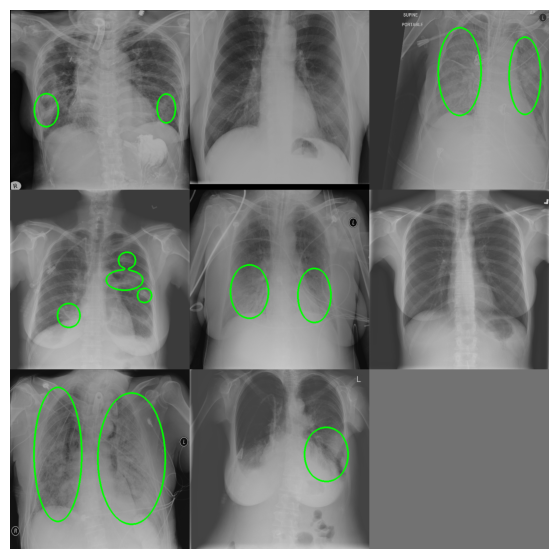

In [78]:
imshow(xs['dat'], ys['pna'], radius = 5)

The test train dataset is the encapsulation of the entire dataset.

In [18]:
data_xs = []
data_ys = []
test_train, test_valid = client.create_generators(test=True)
for xs, ys in test_train:
  data_xs.append(xs['dat'])
  data_ys.append(ys['pna'])
  break

[ 2023-07-31 04:12:44 ] [====================] 100.000% : Iterating | 000800    

Turn the list into an array to display the total size. The size of each sample is (1,512,512,1)

In [79]:
data_xs = np.array(data_xs).reshape(-1, 1, 512, 512, 1)
data_ys = np.array(data_ys).reshape(-1, 1, 512, 512, 1)

print(data_xs.shape)
print(data_ys.shape)

(800, 1, 512, 512, 1)
(800, 1, 512, 512, 1)


This dataset has 800 examples. Let's explore more and see how many cases have pneumonia.

Text(0.5, 1.0, 'Labels')

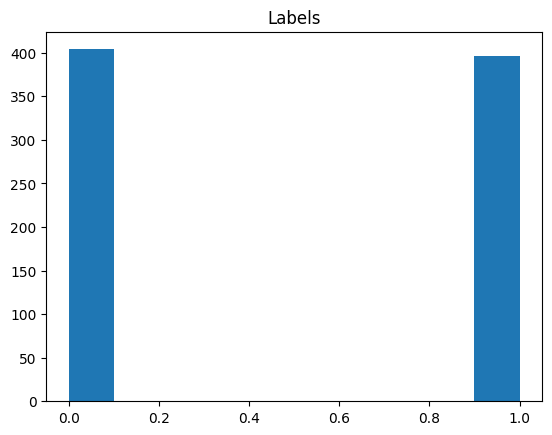

In [42]:
sum_ys = np.sum(data_ys, axis = (1,2,3,4))
labels = []
for i in range(sum_ys.shape[0]):
  if sum_ys[i] > 0:
    labels.append(1)
  else:
    labels.append(0)

plt.hist(labels)
plt.title('Labels')

The classification is about 50/50. Half of the dataset has pneumonia, and the other half does not. Let's check the distribution of the pneumonia amount.

Text(0.5, 1.0, 'Pneumonia Pixel Size Distribution')

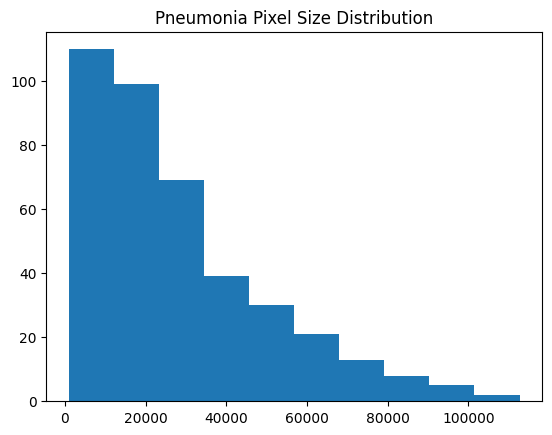

In [80]:
plt.hist(sum_ys[sum_ys > 0])
plt.title('Pneumonia Pixel Size Distribution')

We can see most of pixel size is right skewed. Let's do more statistics.

In [46]:
sum_ys_pd = pd.DataFrame(sum_ys[sum_ys>0])

sum_ys_pd.describe()

,0
count,396.000000
mean,28208.563131
std,22608.962336
min,925.000000
25%,11178.250000
50%,21498.000000
75%,38682.250000
max,112699.000000


Based on this result, most pneumonia size ranges between 925 and 28208 pixels. Let's see how the distribute on the chest changes when is/isn't pneumonia

In [50]:
split_xs = {}
split_xs['no_pna'] = []
split_xs['pna'] = []

for i in range(len(labels)):
  if labels[i] == 1:
    split_xs['pna'].append(data_xs[i, ...].flatten())
  else:
    split_xs['no_pna'].append(data_xs[i, ...].flatten())


Text(0.5, 1.0, 'No Pneumonia Distribution')

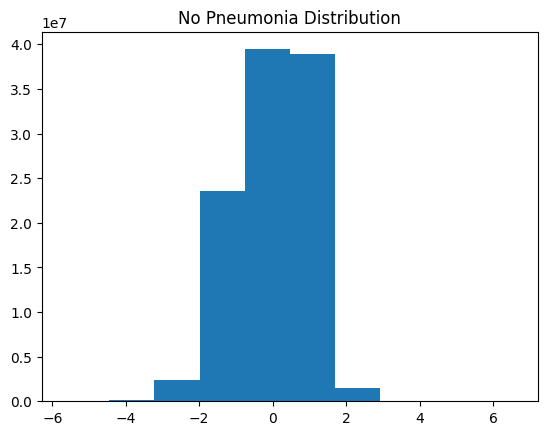

In [81]:
plt.hist(np.array(split_xs['no_pna']).flatten())
plt.title('No Pneumonia Distribution')

Text(0.5, 1.0, 'Pneumonia Distribution')

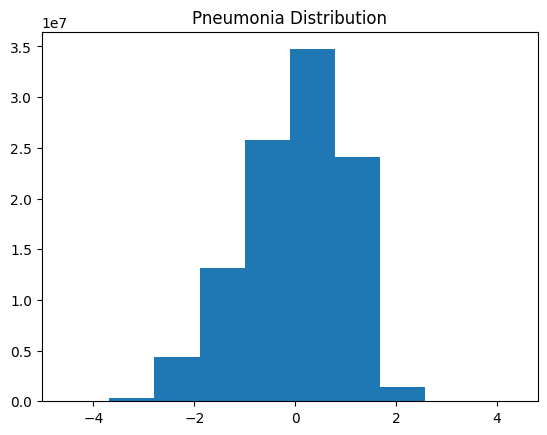

In [82]:
plt.hist(np.array(split_xs['pna']).flatten())
plt.title('Pneumonia Distribution')

There is a slight different in distribution when Pneumonia is present

### Preprocessing

The ResNet-50 backbone used for transfer learning in this experiment requires the following modifications:

* data input must be 2D (H X W) in shape
* data input must be 3 channels in depth
* data input must be scaled between `[0, 1]`

To implement this modifications, consider the following (nested) Python generator function:

In [61]:
#to subsample the data to make it smaller
a = 8

In [62]:
def generator(G):
  for xs, ys in G:

    #To keep the same distribution, we push all values to non-negative and divide by the highest value
    min = np.min(xs['dat'], axis = (1,2,3,4))
    min = min.reshape(8,1,1,1,1)
    xs['dat'] = xs['dat'] - min
    max = np.max(xs['dat'], axis = (1,2,3,4))
    max = max.reshape(8,1,1,1,1)
    xs['dat'] = xs['dat'] / max

    #Resnet input only take RGB inputs
    xs['dat'] = np.tile(xs['dat'].reshape([-1,512,512,1]), (1,1,1,3))
    xs['dat'] = xs['dat'].reshape([8, 512, 512, 3])

    #Resampling the dataset because it reaches the ram capacity
    xs['dat'] = xs['dat'][:, ::a, ::a, :]
    xs['pna'] = ys['pna'][:, 0, ::a, ::a, :]
    yield xs

Pass the default generators into our new generator function to complete the data preprocess step:

In [63]:
gen_train_pp = generator(gen_train)
gen_valid_pp = generator(gen_valid)

### Visualize

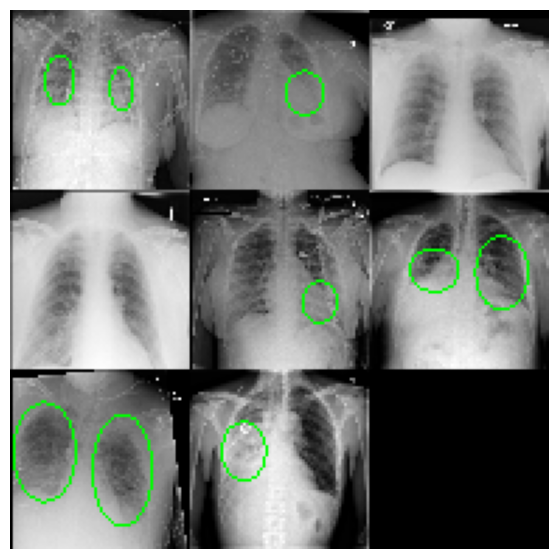

In [64]:
# --- Iterate next batch of data
xs = next(gen_train_pp)

# --- Use imshow(...) to visualize
imshow(xs['dat'], xs['pna'])

The images looks the same but a decrease in quality

# Model

This tutorial will explore pretrained ResNet-50 derivatives trained using the ImageNet.

Note that the ResNet model is implemented with a global average pool in the last convolutional layer; thus any 2D image of arbitrary shape H x W can be used as model input.

In [ ]:
conv = lambda x, filters: layers.Conv2D(filters = filters, kernel_size = (3,3), padding = 'same', strides = 1)(x)
relu = lambda x : layers.LeakyReLU()(x)
norm = lambda x : layers.BatchNormalization()(x)
tran = lambda x, filters: layers.Conv2DTranspose(filters = filters, strides = 2, kernel_size = (3,3), padding = 'same')(x)


conv1 = lambda filters, x: relu(norm(conv(x, filters)))
tran1 = lambda filters, x: tran(x, filters)
concat = lambda x, y: layers.Concatenate()([x,y])

In [ ]:
# --- Define model input
inputs = {'dat': Input(shape=(int(512/a), int(512/a), 3), dtype='float32')}

# --- Define pretrained model
pretrained = ResNet50(include_top = False, weights = 'imagenet', input_tensor = inputs['dat'])

#pretrained.summary()

In [ ]:
l0 = pretrained(inputs['dat'])
l1 = tran1(1024, l0)
l2 = conv1(1024, concat(l1, pretrained.get_layer('conv4_block6_out').output)) #6x6

l3 = tran1(512, l2)
l4 = conv1(512, concat(l3, pretrained.get_layer('conv3_block4_out').output)) #12x2

l5 = tran1(256, l4)
l6 = conv1(256, concat(l5, pretrained.get_layer('conv2_block3_out').output)) #24x24

l7 = tran1(128, l6)
l8 = conv1(128, concat(l7, pretrained.get_layer('conv1_relu').output)) #48x48

l9 = tran1(64, l8)
outputs = layers.Conv2D(filters = 2, kernel_size = (3,3), strides = 1, padding = 'same')(l9)

backbone = Model(inputs = inputs, outputs = outputs)

In [ ]:
inputs = {
    'dat': Input(shape=(int(512/a), int(512/a), 3), name='dat'),
    'pna': Input(shape=(int(512/a), int(512/a), 1), name='pna')}

In [ ]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

In [ ]:
# # --- Define loss object
sce = losses.SparseCategoricalCrossentropy(from_logits=True)

# # --- Create loss tensor
loss = sce(y_true=inputs['pna'], y_pred=logits)

In [ ]:
def calculate_dsc(y_true, y_pred, c=1):
    """
    Method to calculate the Dice score coefficient for given class

    :params

      y_true : ground-truth label
      y_pred : predicted logits scores
           c : class to calculate DSC on

    """
    true = y_true[..., 0] == c
    pred = tf.math.argmax(y_pred, axis=-1) == c

    A = tf.math.count_nonzero(true & pred) * 2
    B = tf.math.count_nonzero(true) + tf.math.count_nonzero(pred)

    return tf.math.divide_no_nan(
        tf.cast(A, tf.float32),
        tf.cast(B, tf.float32))

In [ ]:
# --- Define Dice score
dsc = calculate_dsc(y_true=inputs['pna'], y_pred=logits)

# Model Training

### Compile model

In [ ]:
training = Model(inputs=inputs, outputs={'logits': logits, 'loss': loss, 'dsc': dsc})

In [ ]:
# --- Add loss
training.add_loss(loss)

# --- Add metric
training.add_metric(dsc, name='dsc')

In [ ]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Compile model
training.compile(optimizer=optimizer)

### In-Memory Data

The following line of code will load all training data into RAM memory. This strategy can be effective for increasing speed of training for small to medium-sized datasets.

In [ ]:
# --- Load data into memory
client.load_data_in_memory()

[ 2023-07-24 01:17:03 ] [====================] 100.000% : Iterating | 001000    

### Training

In [ ]:
training.fit(
    x=gen_train_pp,
    steps_per_epoch=100,
    epochs=10,
    validation_data=gen_valid_pp,
    validation_steps=100,
    validation_freq=1)

Epoch 1/10
100/100 [==============================] - 79s 270ms/step - loss: 0.2101 - dsc: 0.5088 - val_loss: 0.7380 - val_dsc: 0.0262
Epoch 2/10
100/100 [==============================] - 24s 238ms/step - loss: 0.1269 - dsc: 0.6962 - val_loss: 0.4408 - val_dsc: 0.2835
Epoch 3/10
100/100 [==============================] - 24s 238ms/step - loss: 0.0942 - dsc: 0.7756 - val_loss: 0.2817 - val_dsc: 0.3280
Epoch 4/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0731 - dsc: 0.8364 - val_loss: 0.2896 - val_dsc: 0.5069
Epoch 5/10
100/100 [==============================] - 22s 222ms/step - loss: 0.0591 - dsc: 0.8665 - val_loss: 0.2539 - val_dsc: 0.5845
Epoch 6/10
100/100 [==============================] - 25s 255ms/step - loss: 0.0508 - dsc: 0.8840 - val_loss: 0.2321 - val_dsc: 0.5653
Epoch 7/10
100/100 [==============================] - 24s 243ms/step - loss: 0.0403 - dsc: 0.9096 - val_loss: 0.2610 - val_dsc: 0.6029
Epoch 8/10
100/100 [==============================] - 2

Compare the results of the trained model segementation to the true values

1/1 [==============================] - 2s 2s/step


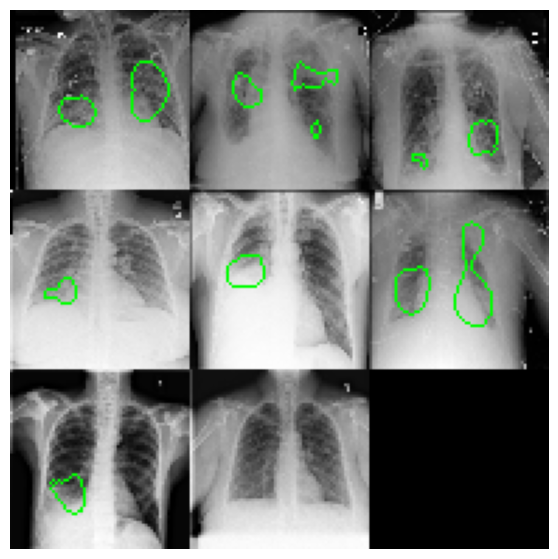

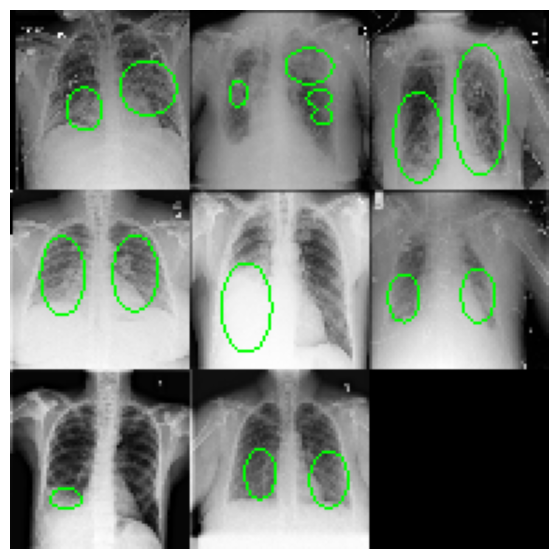

In [ ]:
xs = next(gen_valid_pp)

results = training.predict(xs)
logits = np.argmax(results['logits'], axis = -1)

imshow(xs['dat'], logits)
imshow(xs['dat'], xs['pna'])